In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler
from sklearn.pipeline import make_pipeline


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns 

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

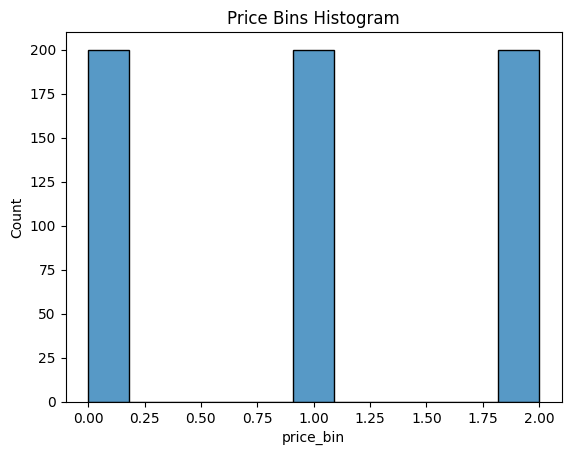

600 datapoints and 12 features


In [2]:
df = pd.read_csv('processed.csv', index_col=0)

df.drop(labels=['Price', 'GPS', 'Brand'], axis=1, inplace=True)

df = df.sample(frac=1, random_state=1)


X = df.drop(labels=['price_bin'], axis=1, inplace=False)
y = df['price_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


over_sampling_strategy = {  
    0: 200,  
    2: 200   
}
under_sampling_strategy = { 
    1: 200
}

ros = RandomOverSampler(random_state=0,sampling_strategy=over_sampling_strategy)
rus = RandomUnderSampler(random_state=0,sampling_strategy=under_sampling_strategy)

pipeline = Pipeline([
    ('over',ros),
    ('under',rus)
])



X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

plt.title('Price Bins Histogram')
sns.histplot(y_resampled)
plt.show()

print(f'{X_resampled.shape[0]} datapoints and {X_resampled.shape[1]} features')

In [3]:
labels = y_train.unique()

### RF

Best Parameter: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 20}
Best f1_macro: 0.8343395217008887
Train Classification Results
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       200
           1       0.91      0.84      0.88       200
           2       0.95      0.99      0.97       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600

Train Confusion Matrix
[[185  15   0]
 [ 21 169  10]
 [  0   1 199]]


c:\Users\user\.conda\envs\cs573\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


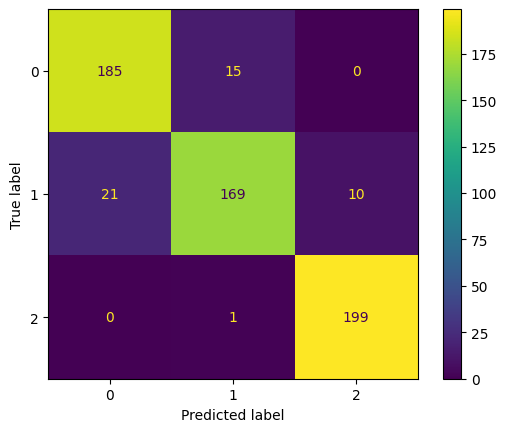

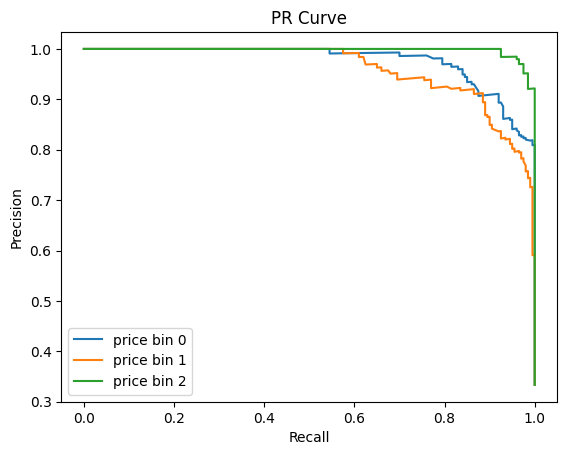

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
pipeline_two = Pipeline([
     ('classifier', RandomForestClassifier())
])
param_grid = {
    'classifier__n_estimators': [4, 8, 16, 20],
    'classifier__max_depth': [None, 4, 8, 16],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [2, 4, 6]
}

def make_model(model,param_grid,scoring,X_train,Y_train):
    np.random.seed(0)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, Y_train)
    
    print("Best Parameter:", grid_search.best_params_)
    print(f"Best {scoring}:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def evaluate_classifier(model,X_train,Y_train,X_test,Y_test):
    
    train_prediction = model.predict(X_train)
    train_proba = model.predict_proba(X_train)
    
    print("Train Classification Results")
    print(classification_report(Y_train,train_prediction))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_train, train_prediction),display_labels= model.classes_)
    disp.plot()
    plt.show()

    precision = {}
    recall = {}

    for i in range(len(labels)):

        precision[i], recall[i], _ = precision_recall_curve(Y_train.to_numpy(), train_proba[:, labels[i]], pos_label=labels[i])
        plt.plot(recall[i], precision[i], label = f'price bin {labels[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc = 'best')
    plt.title('PR Curve')
    plt.show()


model_decision_tree = make_model(pipeline_two,param_grid,'f1_macro',X_resampled,y_resampled)

evaluate_classifier(model_decision_tree,X_resampled,y_resampled,X_test,y_test)

### XGBoost

Best Parameter: {'model__colsample_bylevel': 0.6, 'model__colsample_bytree': 1, 'model__gamma': 0, 'model__max_depth': 8, 'model__n_estimators': 18, 'model__subsample': 0.8}
Train Classification Results
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       200
           1       0.98      0.92      0.95       200
           2       0.99      1.00      1.00       200

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600



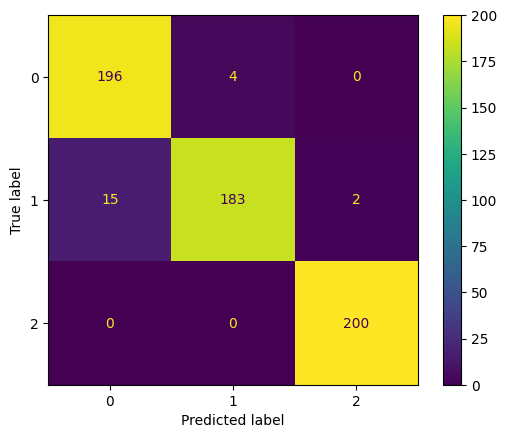

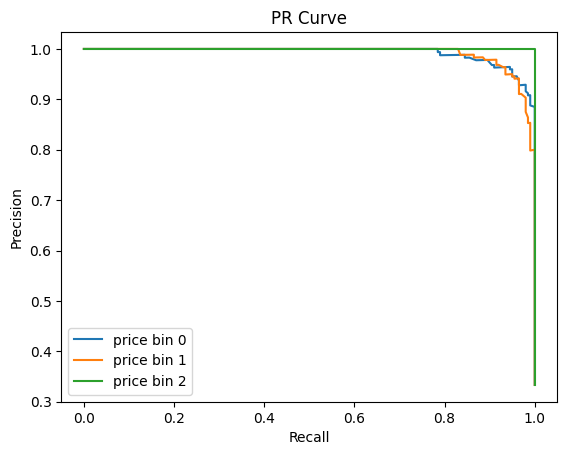

Test Classification Results
              precision    recall  f1-score   support

           0       0.44      0.73      0.55        41
           1       0.90      0.73      0.81       206
           2       0.53      0.76      0.62        25

    accuracy                           0.74       272
   macro avg       0.62      0.74      0.66       272
weighted avg       0.80      0.74      0.75       272



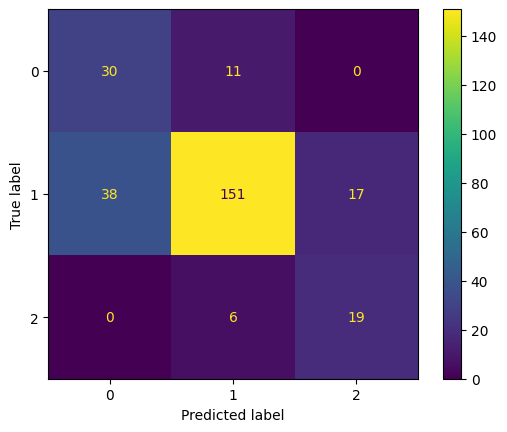

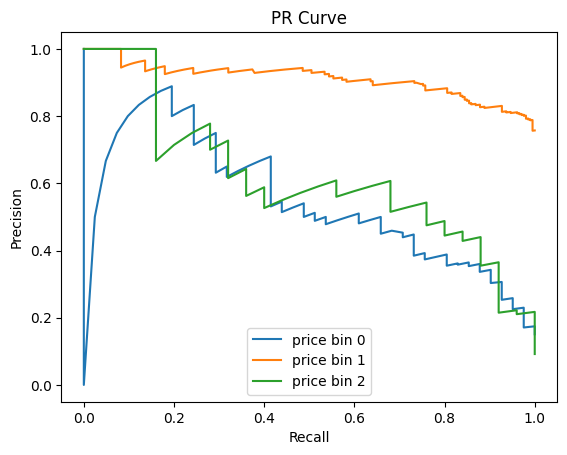

In [4]:

## XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(objective = 'multi:softmax')

pipeline = Pipeline([
    ('model', model)
])

param_grid = {
    'model__max_depth': [2, 4, 8],
    'model__n_estimators': [6, 12, 18],
    'model__colsample_bytree': [1, 0.8, 0.6],
    'model__gamma':[0, 0.1, 0.2, 0.5],
    'model__subsample': [1, 0.9, 0.8, 0.6],
    'model__colsample_bylevel': [1, 0.8, 0.6]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_macro')

grid.fit(X_resampled, y_resampled)

print("Best Parameter:", grid.best_params_)


predictions = grid.predict(X_resampled)
proba = grid.predict_proba(X_resampled)

print("Train Classification Results")
print(classification_report(y_resampled,predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_resampled, predictions))
disp.plot()
plt.show()

precision = {}
recall = {}

for i in range(len(labels)):

    precision[i], recall[i], _ = precision_recall_curve(y_resampled.to_numpy(), proba[:, labels[i]], pos_label=labels[i])
    plt.plot(recall[i], precision[i], label = f'price bin {labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'best')
plt.title('PR Curve')
plt.show()


predictions = grid.predict(X_test)
proba = grid.predict_proba(X_test)

print("Test Classification Results")
print(classification_report(y_test,predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp.plot()
plt.show()

for i in range(len(labels)):

    precision[i], recall[i], _ = precision_recall_curve(y_test.to_numpy(), proba[:, labels[i]], pos_label=labels[i])
    plt.plot(recall[i], precision[i], label = f'price bin {labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'best')
plt.title('PR Curve')
plt.show()

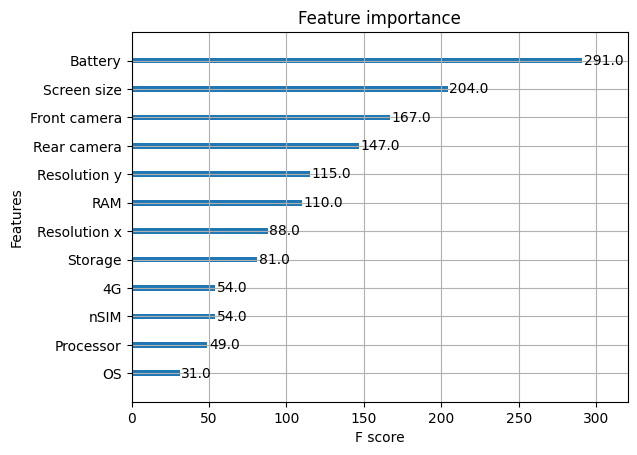

In [18]:
from xgboost import plot_importance


plot_importance(grid.best_estimator_['model'])
plt.show()

c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\.conda\envs\cs573\lib\site-pac

Best Parameter: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (128, 48, 24), 'mlpclassifier__learning_rate_init': 0.0001, 'mlpclassifier__solver': 'adam'}
Best f1_macro: 0.726694869514299
Train Classification Results
              precision    recall  f1-score   support

           0       0.36      0.86      0.50       154
           1       0.94      0.50      0.65       851
           2       0.27      0.87      0.41        82

    accuracy                           0.57      1087
   macro avg       0.52      0.74      0.52      1087
weighted avg       0.80      0.57      0.61      1087



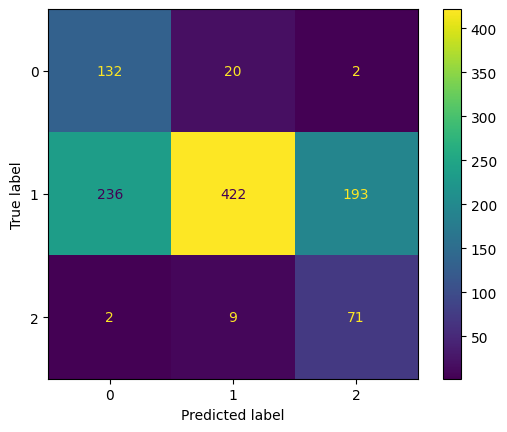

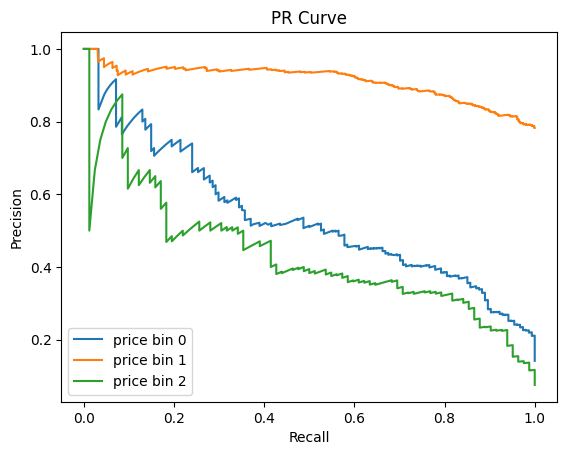

In [27]:
from sklearn.neural_network import MLPClassifier

pipeline = make_pipeline(MLPClassifier(max_iter=500))


param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(128, 64, 24), (128, 48), (128, 48, 24), (64, 24)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['adam', 'sgd'],
    'mlpclassifier__alpha': [0.001, 0.01],
    'mlpclassifier__learning_rate_init': [0.00001, 0.001, 0.0001]
}

def make_model(model,param_grid,scoring,X_train,Y_train):
    np.random.seed(0)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, Y_train)
    
    print("Best Parameter:", grid_search.best_params_)
    print(f"Best {scoring}:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def evaluate_classifier(model,X_train,Y_train,X_test,Y_test):
    
    train_prediction = model.predict(X_train)
    train_proba = model.predict_proba(X_train)
    
    
    print("Train Classification Results")
    print(classification_report(Y_train,train_prediction))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_train, train_prediction),display_labels= model.classes_)
    disp.plot()
    plt.show()

    precision = {}
    recall = {}

    for i in range(len(labels)):

        precision[i], recall[i], _ = precision_recall_curve(Y_train.to_numpy(), train_proba[:, labels[i]], pos_label=labels[i])
        plt.plot(recall[i], precision[i], label = f'price bin {labels[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc = 'best')
    plt.title('PR Curve')
    plt.show()
    



modelmlpc = make_model(pipeline,param_grid,'f1_macro',X_resampled,y_resampled)
evaluate_classifier(modelmlpc,X_train,y_train,X_test,y_test)

Best Parameter: {'classifier__estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 18}
Best f1_macro: 0.6663894596192745
Train Classification Results
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       200
           1       0.49      0.88      0.63       200
           2       0.95      0.39      0.55       200

    accuracy                           0.65       600
   macro avg       0.77      0.65      0.65       600
weighted avg       0.77      0.65      0.65       600



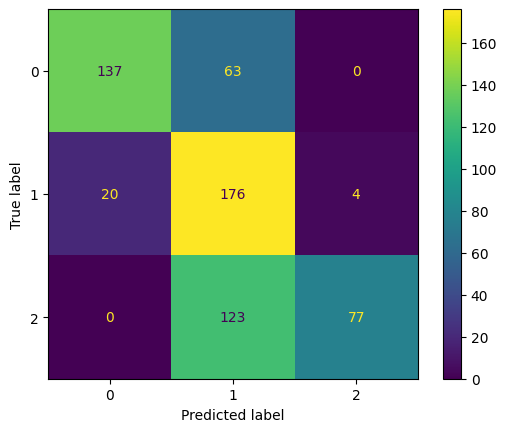

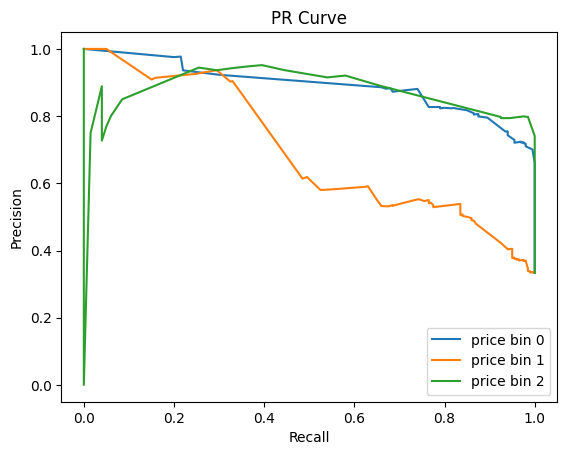

In [26]:
# Adaboost w/ Shallow DT
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
pipeline_two = Pipeline([
     ('classifier', AdaBoostClassifier(algorithm='SAMME'))
])

estimators = []

estimators.append(DecisionTreeClassifier(max_depth=1))
estimators.append(DecisionTreeClassifier(max_depth=2))

param_grid = {
    'classifier__estimator': estimators,
    'classifier__n_estimators': [6, 12, 18, 24, 30, 36],
}

def make_model(model,param_grid,scoring,X_train,Y_train):
    np.random.seed(0)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, Y_train)
    
    print("Best Parameter:", grid_search.best_params_)
    print(f"Best {scoring}:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def evaluate_classifier(model,X_train,Y_train,X_test,Y_test):
    
    train_prediction = model.predict(X_train)
    train_proba = model.predict_proba(X_train)
    
    print("Train Classification Results")
    print(classification_report(Y_train,train_prediction))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_train, train_prediction),display_labels= model.classes_)
    disp.plot()
    plt.show()

    precision = {}
    recall = {}

    for i in range(len(labels)):

        precision[i], recall[i], _ = precision_recall_curve(Y_train.to_numpy(), train_proba[:, labels[i]], pos_label=labels[i])
        plt.plot(recall[i], precision[i], label = f'price bin {labels[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc = 'best')
    plt.title('PR Curve')
    plt.show()
    

    
model_adaboost = make_model(pipeline_two,param_grid,'f1_macro',X_train,y_train)

evaluate_classifier(model_adaboost,X_resampled,y_resampled,X_test,y_test)

c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\.conda\envs\cs573\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\user\.conda\envs\cs573\lib\site-packages\imblearn\pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_st

Best Parameter: {'model__depth': 8, 'model__iterations': 300, 'model__l2_leaf_reg': 0.01, 'model__logging_level': 'Silent', 'model__od_type': 'Iter'}
Train Classification Results
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       200
           1       0.98      0.94      0.96       200
           2       1.00      1.00      1.00       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



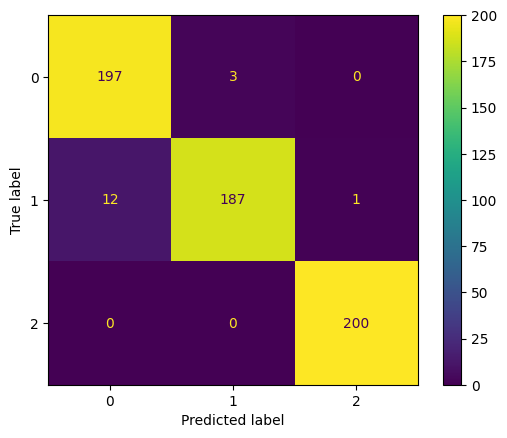

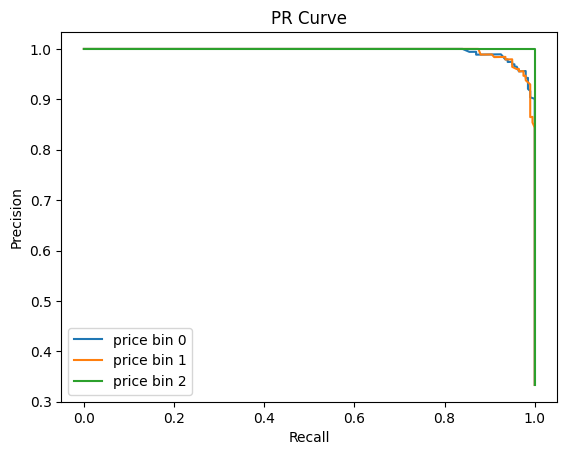

In [33]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

pipeline = Pipeline([
    ('model', model)
])

param_grid = {
    'model__iterations': [200, 250, 300],
    'model__depth': [8, 10, 12],
    'model__l2_leaf_reg': [0.0001, 0.001, 0.01],
    'model__logging_level': ['Silent'],
    'model__od_type': [None, 'Iter']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_macro')

grid.fit(X_resampled, y_resampled)

print("Best Parameter:", grid.best_params_)


predictions = grid.predict(X_resampled)
proba = grid.predict_proba(X_resampled)

print("Train Classification Results")
print(classification_report(y_resampled,predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_resampled, predictions),display_labels= model.classes_)
disp.plot()
plt.show()

precision = {}
recall = {}

for i in range(len(labels)):

    precision[i], recall[i], _ = precision_recall_curve(y_resampled.to_numpy(), proba[:, labels[i]], pos_label=labels[i])
    plt.plot(recall[i], precision[i], label = f'price bin {labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'best')
plt.title('PR Curve')
plt.show()
